## DP2: Control of a differential-drive robot in artificial gravity

## Equations of Motion

In [2]:
# Import everything we need from SymPy
import sympy as sym
import numpy as np
from sympy import Symbol, Matrix
from sympy import N as N_sympy
from sympy import simplify, sin, cos, init_printing
init_printing() # This function will make the outputs of SymPy look prettier and be easier to read

# Constants of the system
m_c = 12.0    # Mass of the chassis in kg
ixx_c = 1.0   # Roll mass moment of ineria of the chassis
iyy_c = 0.8   # Pitch mass moment of interia of the chassis
izz_c = 0.52  # Yaw mass moment of interia of the chassis

m_w = 1.2       # Mass of either wheel in kg
iaa_w = 0.0634  # Axial mass moment of interia of the wheels
itt_w = 0.0327  # Transverse mass moment of interia of the wheels
r_w = 0.325     # Radius of either wheel in meters

m = m_c + 2*m_w        # The total mass of the system
ixx = ixx_c + 2*itt_w  # The total roll mass moment of inertia of the system
iyy = iyy_c            # The total pitch mass moment of inertia of the system
izz = izz_c + 2*itt_w  # The total yaw mass moment of inertia of the system

h = 0.2   # Distance from the CoM of the chassis to wheel axle in meters
a = 0.35  # Half the distance between the wheels in meters

r_station = 20.0  # The radius of the station in meters
v_station = -0.1  # The angular velocity of the station in rad/second

# Create the system's generalized coordinates 
e_lat = Symbol('e_lat')          # The lateral error of the segbot. Positive is to the left of the target position.
phi = Symbol('phi')              # The yaw of the chassis of the segbot relative to the station. Positive is facing left.
phidot = Symbol('phidot')        # The yawing velocity of the segbot relative to the station. Positive is turning left.
v = Symbol('v')                  # The forward velocity of the segbot. Positive is moving forward.
theta = Symbol('theta')          # The pitch of the chassis of the segbot. Positive is tipped forwards.
thetadot = Symbol('thetadot')    # The pitching velocity of the segbot. Positive is tipping forward.
tau_l = Symbol('tau_l')          # The torque applied to the left wheel of the segbot. Positive moves the segbot forward.
tau_r = Symbol('tau_r')          # The torque applied to the right wheel of the segbot. Positive moves the segbot forward.

M = Matrix([[m + 2 * iaa_w / r_w**2, 0, m_c * h * cos(theta)],
            [0, (ixx + m_c * h**2) * sin(theta)**2 + izz * cos(theta)**2 + (2 * iaa_w * a**2 / r_w**2) + 2 * m_w * a**2, 0],
            [m_c * h * cos(theta), 0, iyy * m_c * h**2]])
N = Matrix([[m_c * h * (phidot**2 + thetadot**2) * sin(theta)],
            [-2 * (ixx - izz + m * h**2) * cos(theta) * sin(theta) * phidot * thetadot - m_c * h * sin(theta) * v * phidot],
            [(ixx - izz + m_c * h**2) * cos(theta) * sin(theta) * phidot**2 + m_c * 9.81 * h * sin(theta)]])
R = Matrix([[1 / r_w, 1 / r_w],
            [-a / r_w, a / r_w],
            [-1, -1]])
f_partial = simplify(M.inv() * (N + R * Matrix([[tau_l], [tau_r]])))
f = Matrix([[v * sin(phi)],
            [f_partial]])
f = simplify(f)
f


⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                -18.4325593081475⋅τₗ - 18.4325593081475⋅τᵣ - 14.377396260355⋅
⎢                ─────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                     89.85872
⎢                                                                             
⎢                                                  -1.056⋅φ̇⋅θ̇⋅sin(2⋅θ) - 2.4
⎢                                                  ───────────────────────────
⎢                                                                             
⎢                                                                          0.9
⎢                                                   

## Equations of Motion Standardization and Linearization

In [3]:
# FIXME: Find an equilibrium point and linearize the system into state space form
state_vector = sym.Matrix([e_lat, phi, v, theta, thetadot, phidot])
input_vector = sym.Matrix([tau_l, tau_r])

equilibrium = {e_lat:0, phi: 0, v: 2, theta: 0, thetadot: 0, phidot: 0, tau_l: 0, tau_r: 0}

# Redefine the new system dynamics to include both e_lat_dot and e_lat_doubledot
f_state = sym.Matrix([
    v * sym.sin(phi),        # derivative of e_lat (lateral velocity)
    phidot,                  # derivative of phi (yaw rate)
    f_partial[0],            # derivative of v (forward velocity dynamics)
    thetadot,                # derivative of theta (pitch angle)
    f_partial[2],            # derivative of thetadot (pitching velocity)
    f_partial[1]             # derivative of phidot (yawing velocity)
])

# Create the standard form of the system dynamics: f(x, u)
f_standard = simplify(f_state)

# Compute the Jacobians A and B
A_jacobian_full = simplify(f_standard.jacobian(state_vector))
B_jacobian_full = simplify(f_standard.jacobian(input_vector))

A_eq = A_jacobian_full.subs(equilibrium)
B_eq = B_jacobian_full.subs(equilibrium)

# Display the updated linearized matrices
A_eq_simplified = simplify(A_eq)
B_eq_simplified = simplify(B_eq)

A_eq_simplified, B_eq_simplified, f_standard

⎛                                                                            ⎡
⎜                                                                            ⎢
⎜                                                                            ⎢
⎜                                                                            ⎢
⎜                                                                            ⎢
⎜                                                                            ⎢
⎜⎡0  2  0          0          0  0⎤  ⎡        0                  0        ⎤  ⎢
⎜⎢                                ⎥  ⎢                                    ⎥  ⎢
⎜⎢0  0  0          0          0  1⎥  ⎢        0                  0        ⎥  ⎢
⎜⎢                                ⎥  ⎢                                    ⎥  ⎢
⎜⎢0  0  0  -245.056661411115  0  0⎥  ⎢15.5326172644856   15.5326172644856 ⎥  ⎢
⎜⎢                                ⎥, ⎢                                    ⎥, ⎢
⎜⎢0  0  0          0          1  0⎥  ⎢        0     

## Check Controllability

In [4]:
import numpy as np
from sympy import Matrix

# Convert SymPy matrices to NumPy for numerical computations
A_num = np.array(A_eq).astype(np.float64)
B_num = np.array(B_eq).astype(np.float64)

# Define a function to compute the controllability matrix
def controllability_matrix(A, B):
    n = A.shape[0]
    controllability = B
    for i in range(1, n):
        controllability = np.hstack((controllability, np.linalg.matrix_power(A, i) @ B))
    return controllability

# Compute the controllability matrix
Ctrb = controllability_matrix(A_num, B_num)

# Compute its rank
rank = np.linalg.matrix_rank(Ctrb)

print(f"Controllability Matrix Rank: {rank} / {A_num.shape[0]}")

Controllability Matrix Rank: 6 / 6


## Gain Selection and Controller Design

In [5]:
# FIXME: Select a set of control and observer gains. Ensure the resultant system is stable. Implement your controller below.
import numpy as np
from scipy.linalg import solve_continuous_are

# Define the Q and R matrices for LQR
Q = np.diag([5, 2, 2, 600, 10, 5])
R = np.array([[1, 0], [0, 1]])

# Solve for gain matrix
P = solve_continuous_are(A_num, B_num, Q, R)

#Calculate the LQR gain matrix K
K = np.linalg.inv(R) @ B_num.T @ P
K

array([[ -1.58113883,  -4.12839019,  -1.        , -27.46636474,
         -2.45795321,  -2.53671678],
       [  1.58113883,   4.12839019,  -1.        , -27.46636474,
         -2.45795321,   2.53671678]])

In [6]:
np.linalg.eig(A_num - B_num@K)

EigResult(eigenvalues=array([-1.00523902e+00+0.99635925j, -1.00523902e+00-0.99635925j,
       -3.31238733e+00+0.j        , -4.50348191e+02+0.j        ,
       -8.45395315e+00+0.j        , -1.65041684e-01+0.j        ]), eigenvectors=array([[-5.60692452e-03-6.31919095e-01j, -5.60692452e-03+6.31919095e-01j,
         1.71906897e-01+0.00000000e+00j,  1.42231013e-20+0.00000000e+00j,
        -6.31213873e-17+0.00000000e+00j,  5.20894056e-14+0.00000000e+00j],
       [ 3.17627368e-01+3.14821610e-01j,  3.17627368e-01-3.14821610e-01j,
        -2.84711114e-01+0.00000000e+00j,  4.94285585e-18+0.00000000e+00j,
         2.27934430e-16+0.00000000e+00j, -4.25276647e-15+0.00000000e+00j],
       [-1.26698677e-15-1.93031737e-15j, -1.26698677e-15+1.93031737e-15j,
         7.83511871e-16+0.00000000e+00j,  1.53946839e-01+0.00000000e+00j,
        -1.10270756e-01+0.00000000e+00j, -9.98590779e-01+0.00000000e+00j],
       [ 1.76800341e-16+2.90297396e-16j,  1.76800341e-16-2.90297396e-16j,
        -8.88378871e-17+0

## Controller

In [135]:
# Necessary imports
from scipy.linalg import solve_continuous_are
import numpy as np

# Controller class
class Controller():
    def __init__(self):
        
        self.K = K
         
    def reset(self):
        pass        

    def run(self, **kwargs):

        # Extract the current state from kwargs
        e_lat = kwargs["e_lat"]
        phi = kwargs["phi"]
        v = kwargs["v"]
        theta = kwargs["theta"]
        thetadot = kwargs["thetadot"]
        phidot = kwargs["phidot"]
        
        # Create the state vector based on the current values
        state = np.array([e_lat, phi, v, theta, thetadot, phidot])
        
        # Compute the control input u = -Kx (negative feedback)
        u = -np.dot(self.K, state)
        
        # The control input u gives [left_torque, right_torque]
        left_torque = u[0]
        right_torque = u[1]
        
        # Return the computed torques as the inputs
        inputs = [left_torque, right_torque]
        return inputs

        

In [136]:
# Create an instance of our Controller class
controller = Controller()


## Running the Simulation

In [137]:
# Import the segbot project. This module is used to simulate, render, and plot a segbot dynamic system
import ae353_segbot

In [138]:
sim = ae353_segbot.Segbot_sim(use_keyboard=True,
                              visualization=True,
                              animation=False,
                              bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7011/static/


In [139]:
# Run the simulation and collect the simulation data
data = sim.run(controller,
               max_time=30,
               initial_e_lat = 0.5,
               station_velocity = -0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
RESET
PAUSED
RESUME
RESET
RESET
RESET
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
PAUSED
RESUME
RESET
PAUSED
RESUME
PAUSED
RESUME


## Post-processing the simulation data

In [145]:
# Import the pyplot module from the matplotlib package
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

## Pitch vs. Time with Torque vs. Time Plots

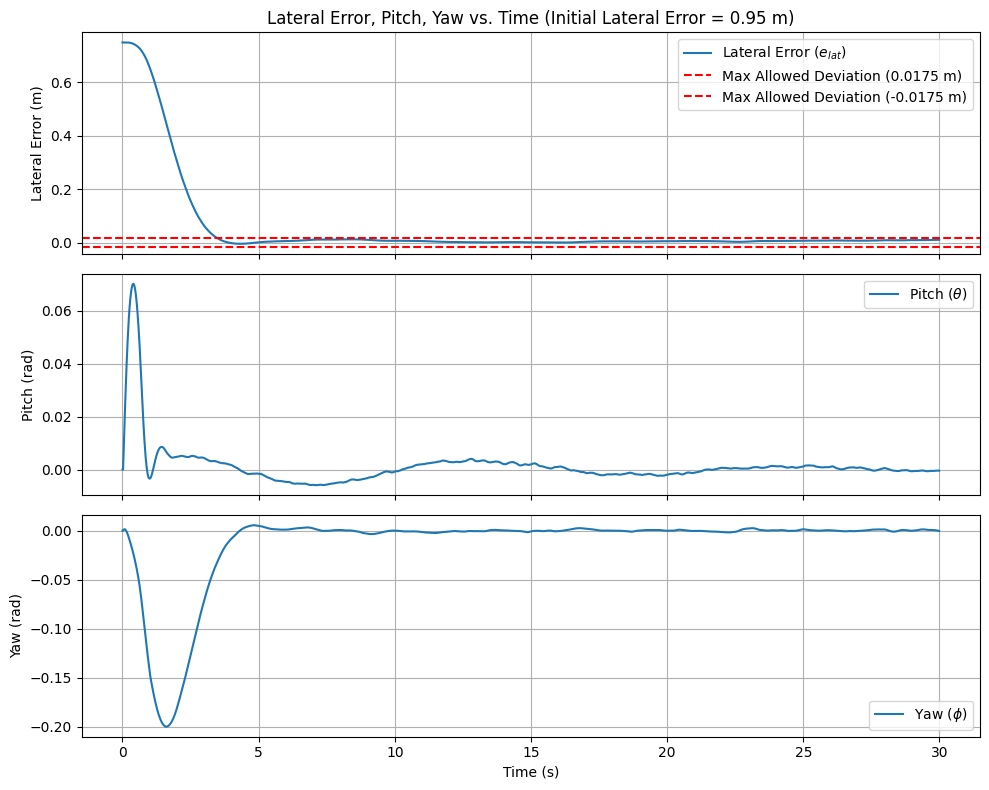

In [146]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
# Simulation time settings

# Plot lateral error
ax[0].set_title("Lateral Error, Pitch, Yaw vs. Time (Initial Lateral Error = 0.95 m)")
ax[0].plot(data['time'], data['e_lat'], label='Lateral Error ($e_{lat}$)')
ax[0].axhline(0.0175, color='r', linestyle='--', label='Max Allowed Deviation (0.0175 m)')
ax[0].axhline(-0.0175, color='r', linestyle='--', label='Max Allowed Deviation (-0.0175 m)')
ax[0].set_ylabel('Lateral Error (m)')
ax[0].legend()
ax[0].grid(True)

# Plot pitch angle|
ax[1].plot(data['time'], data['theta'], label='Pitch ($\\theta$)')
ax[1].set_ylabel('Pitch (rad)')
ax[1].legend()
ax[1].grid(True)

# Plot yaw angle

ax[2].plot(data['time'], data['phi'], label='Yaw ($\\phi$)')
ax[2].set_ylabel('Yaw (rad)')
ax[2].set_xlabel('Time (s)')
ax[2].legend()
ax[2].grid(True)

# Show the plots
plt.tight_layout()
plt.show()

## Finding Settling Time and Max After Settling for Verification

In [147]:
max_lateral_error = np.max(np.abs(data["e_lat"]))
print(f"Maximum Lateral Error: {max_lateral_error:.4f} meters")

threshold = 0.0175  # Maximum allowable lateral error
settling_time_index = np.argmax(10 <= threshold)  # Find the first time it stays within 0.02m
settling_time = data["time"][settling_time_index]
print(f"Settling Time: {settling_time:.2f} seconds")

Maximum Lateral Error: 0.7503 meters
Settling Time: 0.00 seconds


In [148]:
import numpy as np

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

data["time"] = np.array(data["time"])
data["e_lat"] = np.array(data["e_lat"])

threshold = 0.0175

tolerance = 0.001
settling_time_index = np.argmax(np.abs(data["e_lat"]) <= (threshold + tolerance))
settling_time = data["time"][settling_time_index]

time_check = settling_time + 10

time_check_index = np.where(data["time"] >= time_check)[0][0]

window_size = 100
e_lat_smooth = moving_average(data["e_lat"], window_size)

e_lat_after_settling_10s = e_lat_smooth[settling_time_index:time_check_index]

within_threshold_10s = np.all(np.abs(e_lat_after_settling_10s) <= threshold)

print(f"Settling Time: {settling_time:.2f} seconds")
print(f"Time checked: 10 seconds after settling (until {time_check:.2f} seconds)")

if within_threshold_10s:
    print("The lateral error remains within the threshold for 10 seconds after settling.")
else:
    print("The lateral error exceeds the threshold during the 10 seconds after settling.")



Settling Time: 3.45 seconds
Time checked: 10 seconds after settling (until 13.45 seconds)
The lateral error remains within the threshold for 10 seconds after settling.


In [149]:
import numpy as np

threshold = 0.0175
tolerance = 0.001  # Small tolerance to account for noise

settling_time_index = np.argmax(np.abs(data["e_lat"]) <= (threshold + tolerance))
settling_time = data["time"][settling_time_index]

# Step 2: Define the time range to check (10 seconds after the settling time)
time_check = settling_time + 10  # Time 10 seconds after the settling time

# Find the index corresponding to 10 seconds after the settling time
time_check_index = np.where(data["time"] >= time_check)[0][0]  # Find the index corresponding to t >= settling_time + 10

# Step 3: Extract data AFTER the 10-second window
e_lat_after_10s = data["e_lat"][time_check_index:]

# Step 4: Calculate the maximum lateral error after the 10-second window
max_lateral_error_after_10s = np.max(np.abs(e_lat_after_10s))

# Output the maximum lateral error and corresponding times
print(f"Settling Time: {settling_time:.2f} seconds")
print(f"Maximum Lateral Error After 10 seconds: {max_lateral_error_after_10s:.4f} meters")

Settling Time: 3.45 seconds
Maximum Lateral Error After 10 seconds: 0.0102 meters


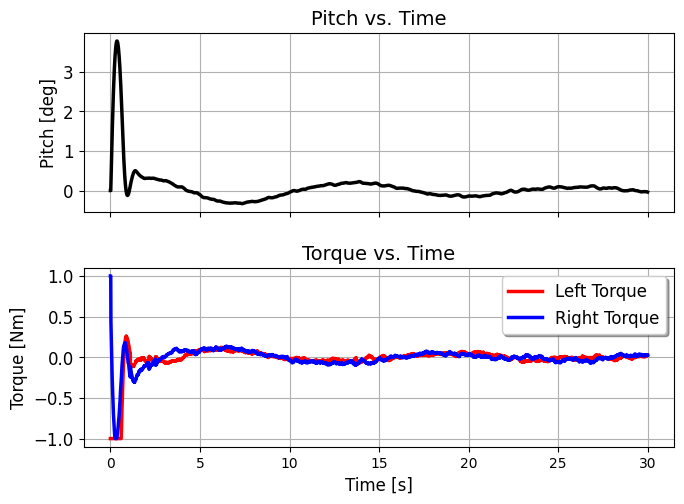

In [81]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

# Create a plot of the pitch angle versus time on the first plot
axes[0].plot(data['time'], 180.*np.array(data['theta'])/np.pi, c='k', lw=2.5)
axes[0].set_ylabel("Pitch [deg]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Pitch vs. Time", fontsize=14)
axes[0].grid()

# Create a plot of the torque versus time on the second plot
axes[1].plot(data['time'], data['tau_l'], label="Left Torque", c='r', lw=2.5)
axes[1].plot(data['time'], data['tau_r'], label="Right Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].legend(fontsize=12, shadow=True)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()

## Yaw Angle vs. Time Plot

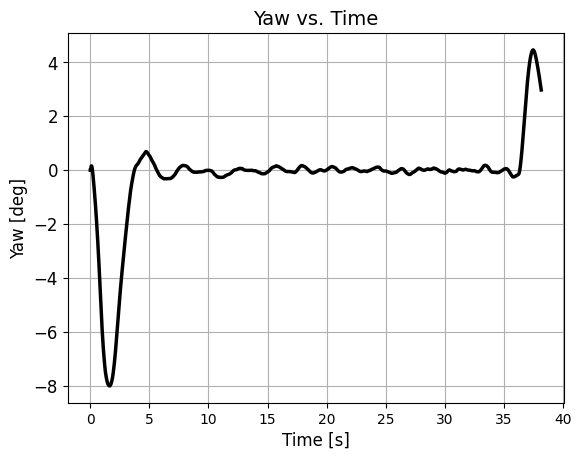

In [108]:
# Create a plot of the pitch angle versus time on the first plot
plt.plot(data['time'], 180.*np.array(data['phi'])/np.pi, c='k', lw=2.5)
plt.ylabel("Yaw [deg]", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title("Yaw vs. Time", fontsize=14)
plt.grid()

plt.show()

## E_lat vs. Time Plot

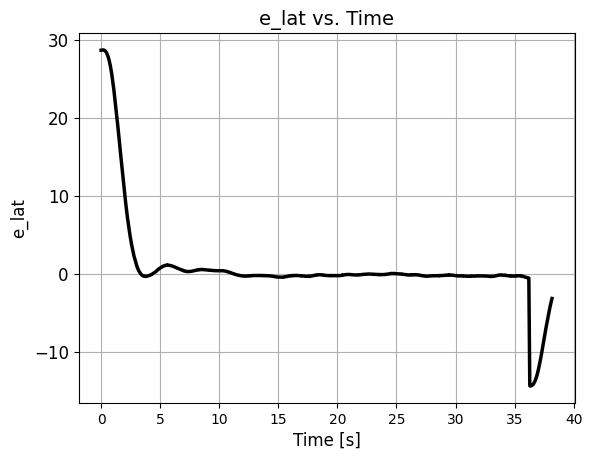

In [109]:
# Create a plot of the pitch angle versus time on the first plot
plt.plot(data['time'], 180.*np.array(data['e_lat'])/np.pi, c='k', lw=2.5)
plt.ylabel("e_lat", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title("e_lat vs. Time", fontsize=14)
plt.grid()

plt.show()

## Verification of Requirement

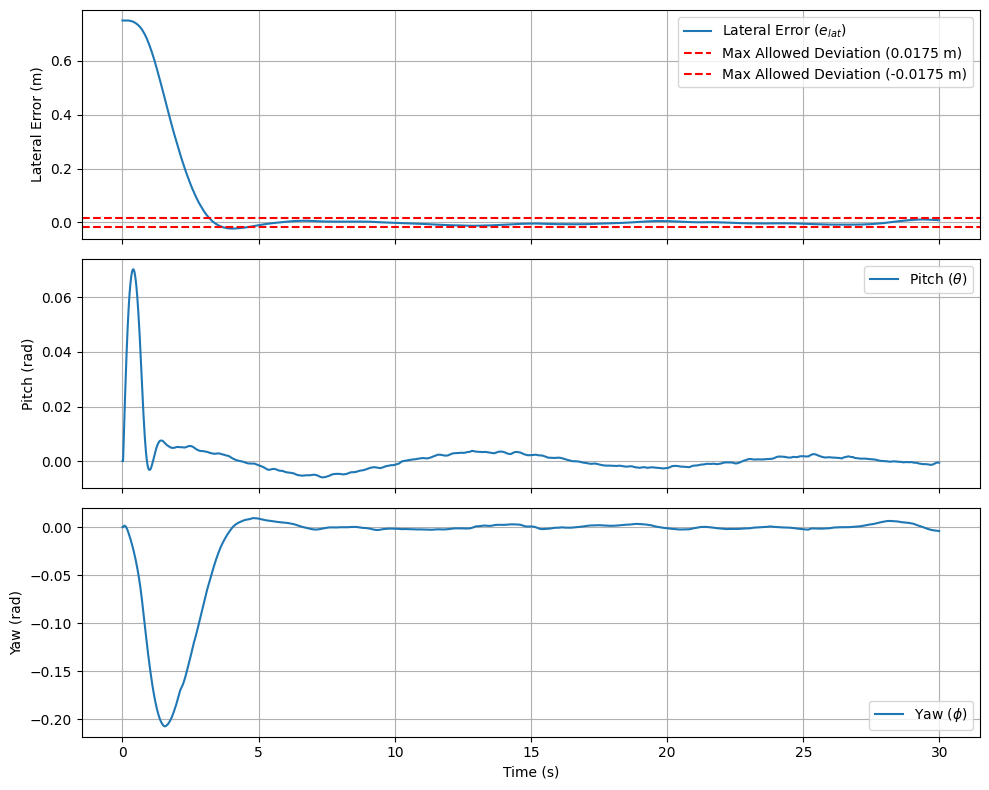

In [291]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
# Simulation time settings
plt.title("Lateral Erro, Pitch, Yaw vs. Time (Initial Lateral Error = 0.75 m)")
# Plot lateral error
ax[0].plot(data['time'], data['e_lat'], label='Lateral Error ($e_{lat}$)')
ax[0].axhline(0.0175, color='r', linestyle='--', label='Max Allowed Deviation (0.0175 m)')
ax[0].axhline(-0.0175, color='r', linestyle='--', label='Max Allowed Deviation (-0.0175 m)')
ax[0].set_ylabel('Lateral Error (m)')
ax[0].legend()
ax[0].grid(True)

# Plot pitch angle|
ax[1].plot(data['time'], data['theta'], label='Pitch ($\\theta$)')
ax[1].set_ylabel('Pitch (rad)')
ax[1].legend()
ax[1].grid(True)

# Plot yaw angle

ax[2].plot(data['time'], data['phi'], label='Yaw ($\\phi$)')
ax[2].set_ylabel('Yaw (rad)')
ax[2].set_xlabel('Time (s)')
ax[2].legend()
ax[2].grid(True)

# Show the plots
plt.tight_layout()
plt.show()